# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять специалиста в области Data Science.

Василий представляет нам набор данных о добыче газа на своих скважинах.\
Загрузите данные: https://lms-cdn.skillfactory.ru/assets/courseware/v1/71b705fb3dda956399b2209697366543/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/_unconv.zip

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Бизнес-задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты нашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.

Импортируем необходимые библиотеки:

In [17]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
%matplotlib inline

from sklearn.metrics import mean_absolute_percentage_error, r2_score   # метрики оценки модели
from sklearn.linear_model import LinearRegression                      # линейная регрессия по методу МНК
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate

import warnings
warnings.simplefilter('ignore')

Прочитаем исходные данные:

In [18]:
# загружаем данные
data = pd.read_csv('_unconv.zip')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.080,2.920,2.800,81.400,1.160,2.310,4165.196
1,2,12.380,3.530,3.220,46.170,0.890,1.880,3561.146
2,3,14.020,2.590,4.010,72.800,0.890,2.720,4284.349
3,4,17.670,6.750,2.630,39.810,1.080,1.880,5098.681
4,5,17.520,4.570,3.180,10.940,1.510,1.900,3406.133


## Классическая линейная регрессия по методу наименьших квадратов

Итак, первая часть: построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

### 1. Описательный анализ данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB
None
                                  count     mean     std      min      25%  \
идентификатор                   200.000  100.500  57.879    1.000   50.750   
пористость скважины             200.000   14.991   2.971    6.550   12.912   
проницаемость скважины          200.000    4.331   1.731    1.130    3.123   
акустический импеданс           200.000    2.969   0.567    1.280    2.547   
коэффициент хрупкости скважины  200.000   48.162  14.129   10.940   37

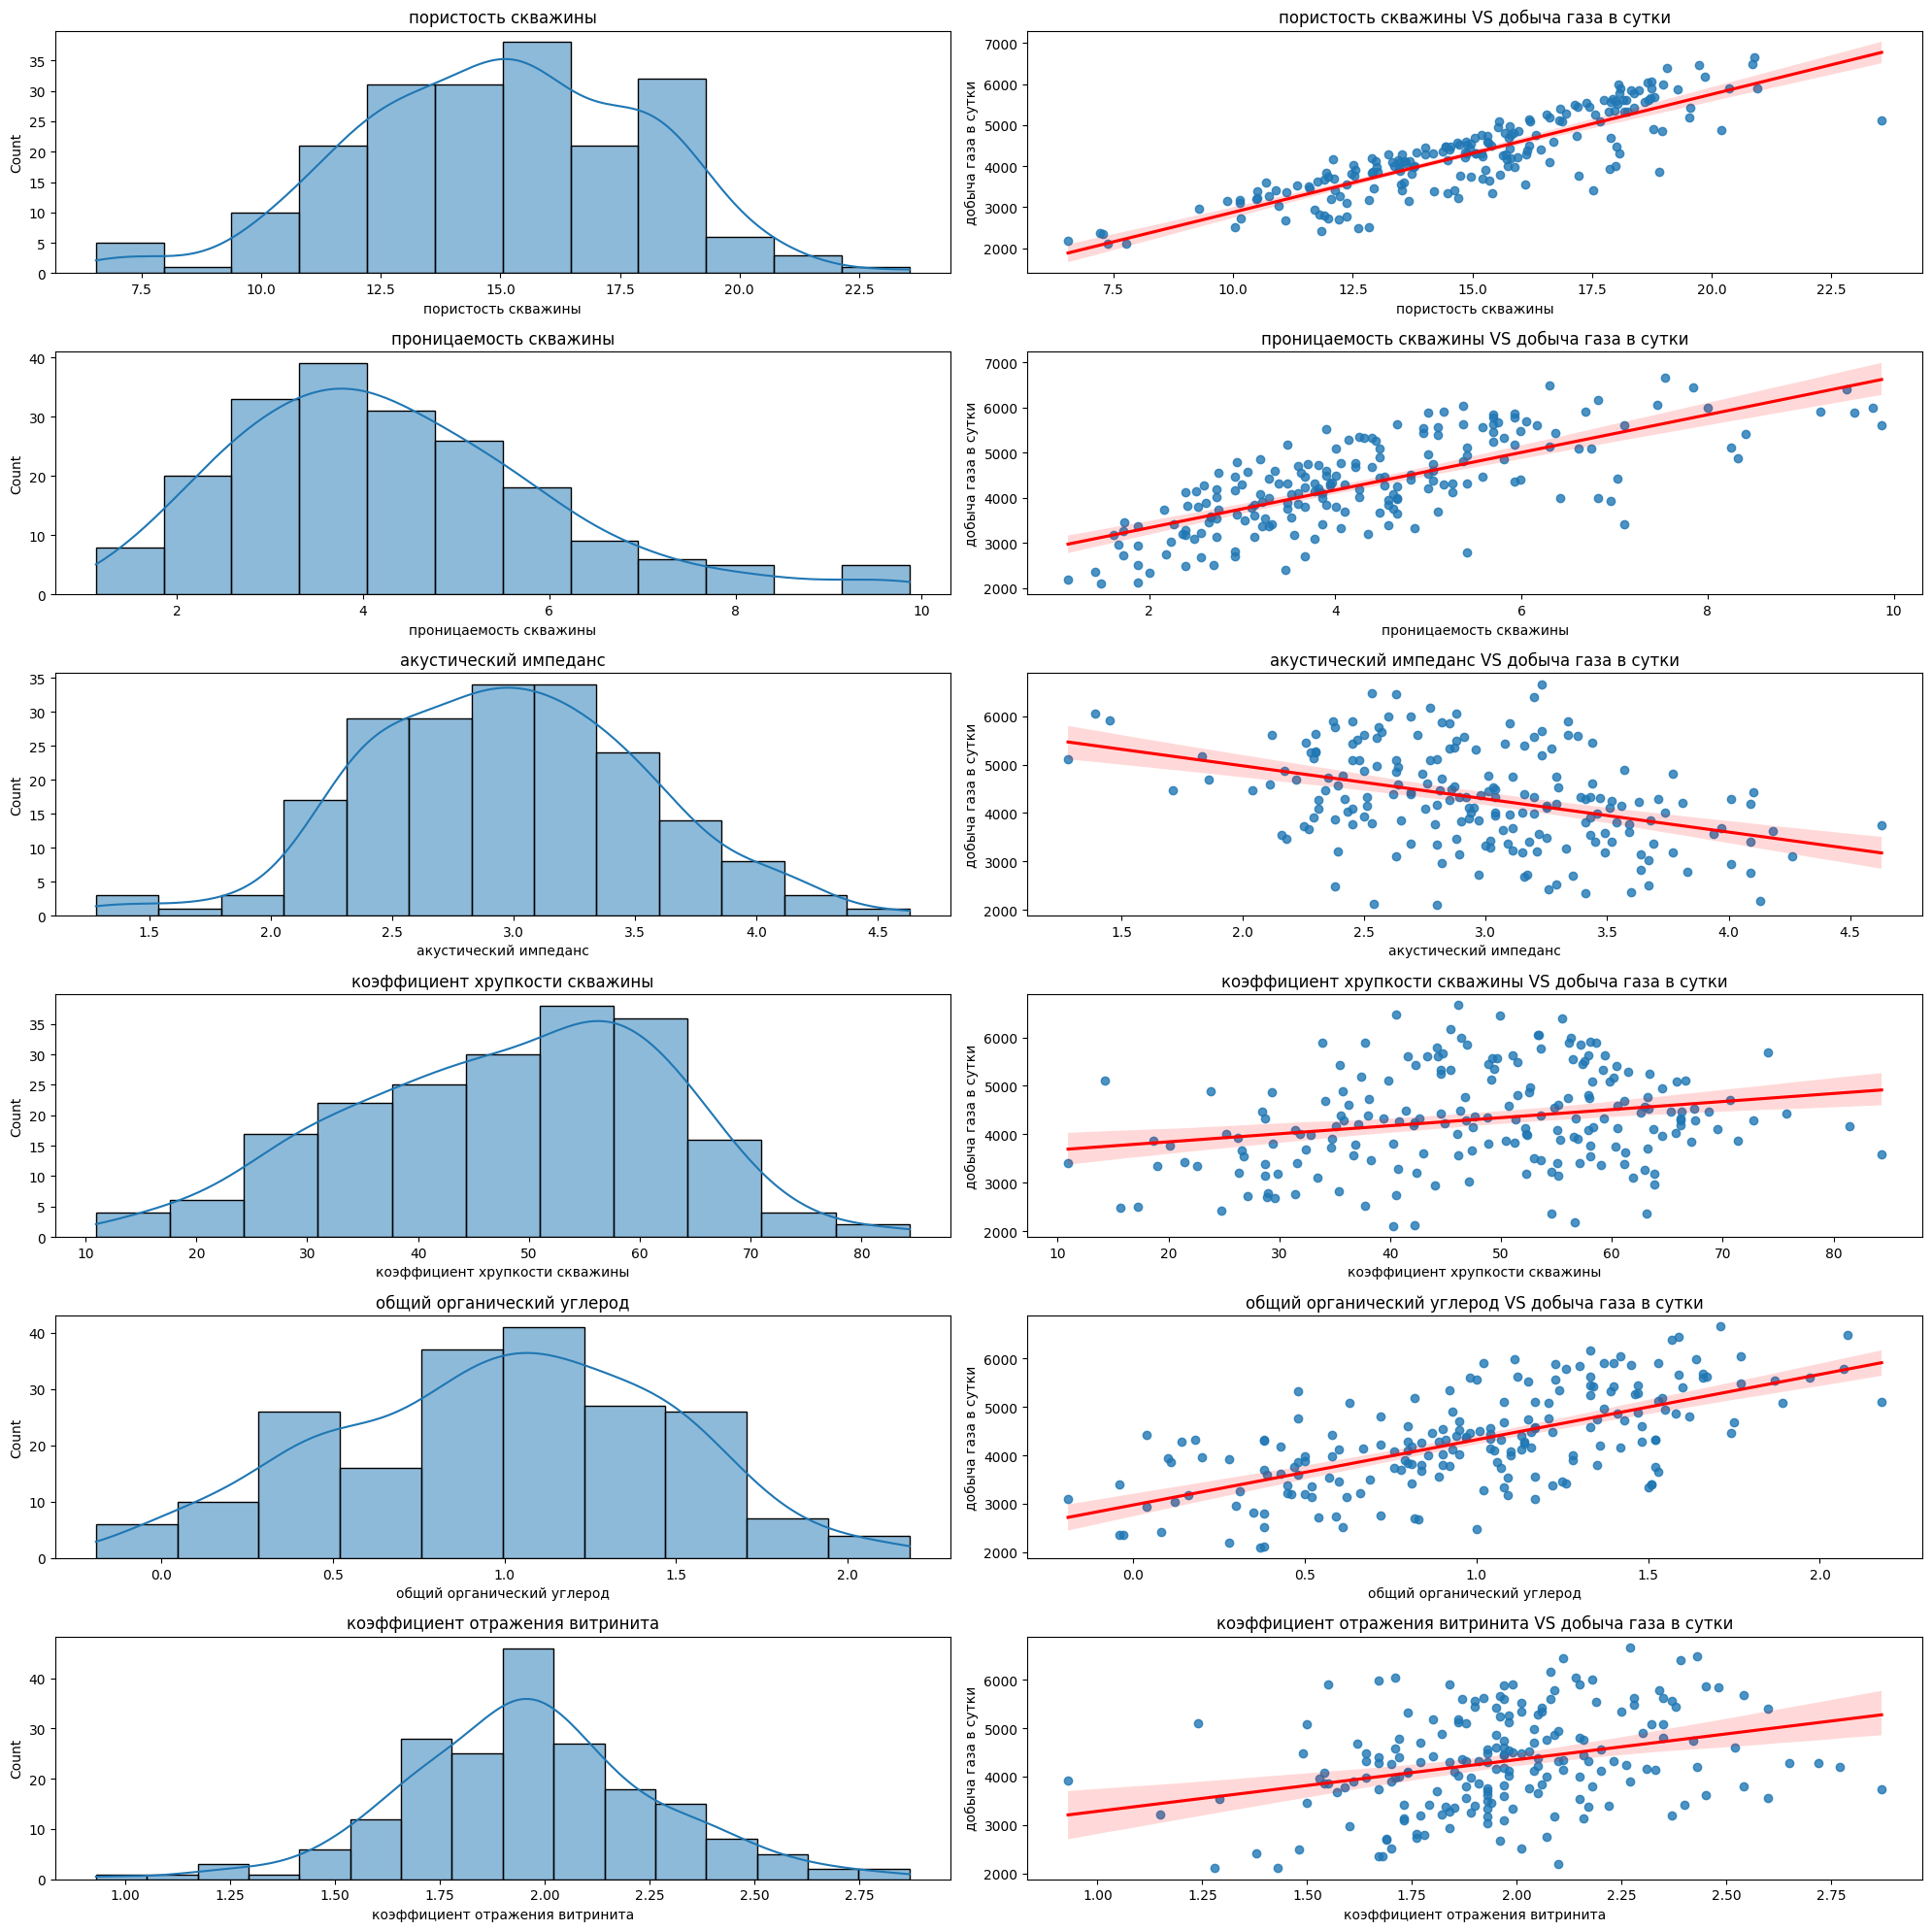

In [19]:
# посмотрим на общую информацию: количество объектов, пропуски, типы данных
print(data.info())

# переименуем буквенные обозначения столбцов в названия
data = data.rename(columns = {'Well': 'идентификатор', 'Por': 'пористость скважины', 'Perm': 'проницаемость скважины', 'AI': 'акустический импеданс',
                       'Brittle': 'коэффициент хрупкости скважины', 'TOC': 'общий органический углерод',
                       'VR': 'коэффициент отражения витринита', 'Prod': 'добыча газа в сутки'})

# посмотрим на статистические показатели признаков
print(data.describe().T)

fig, axes = plt.subplots(6, 2, figsize=(20, 20))
# создаем цикл для всех признаков, кроме целевого и неинформативного идентификатора
for i, feature in enumerate(data.drop(['идентификатор','добыча газа в сутки'], axis=1).columns):
    # строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, kde=True, ax=axes[i][0])
    # название гистограммы
    histplot.set_title('{}'.format(feature))
    # строим диаграмму рассеяния + линейную регрессию в зависимости от целевого признака
    regplot = sns.regplot(data=data, x=feature, y='добыча газа в сутки', line_kws=dict(color="r"), ax=axes[i][1])
    # название графика
    regplot.set_title('{} VS добыча газа в сутки'.format(feature));
plt.tight_layout()                                                                  #выравнивание графиков

<font color='blue'>**ВЫВОДЫ:**
* В признаках присутствует неинформативный - уникальный идентификатор(номер скважины). После корреляционного анализа и изучения его влияния на уравнение регрессии данный фактор мы удалим.
* Мы наблюдаем наибольшую зависимость целевого признака с факторами: пористость и проницаемость скважины, особенно с ростом показателя пористости растет добыча газа.
* Коэффициент хрупкости скважины, исходями из графика рассеяния, имеет низкую дисперсию и никак не влияет на добычу газа.
* В остальных признаках также наблюдается довольно низкая дисперсия, немного лучше дисперсия с целевым признаком у углерода.
* Все признаки числовые и не имеют пропусков, мы не наблюдаем больших выбросов: среднее и медианы похожи у всех признаков.

### 2. Корреляционный анализ

В результате анализа матрицы корреляций ответим на следующие вопросы:
* Какие факторы сильнее всего коррелируют с целевой переменной?
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю) согласно рангу матрицы и ее определителю?
* Присутствует ли коллинеарность/мультиколлинеарность в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

Ранг матрицы корреляций: 8
Определитель: 0.0007300


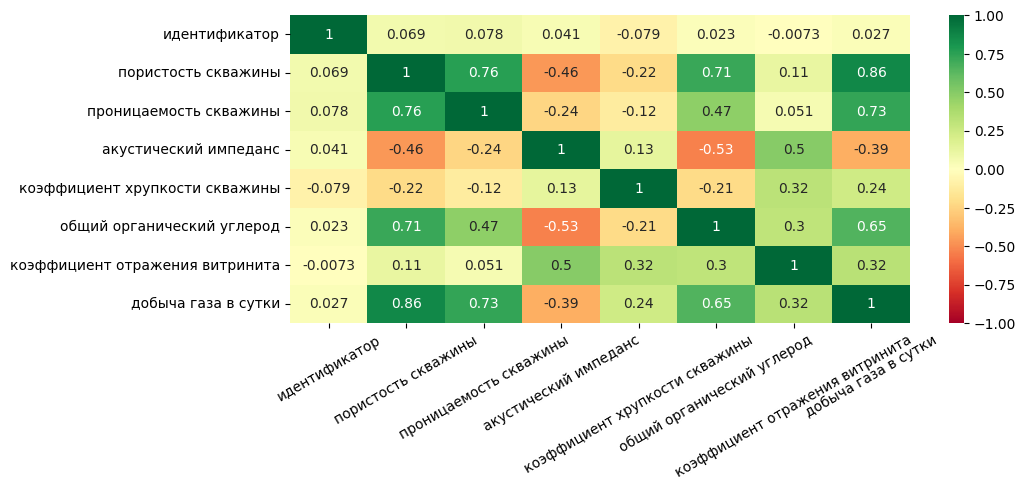

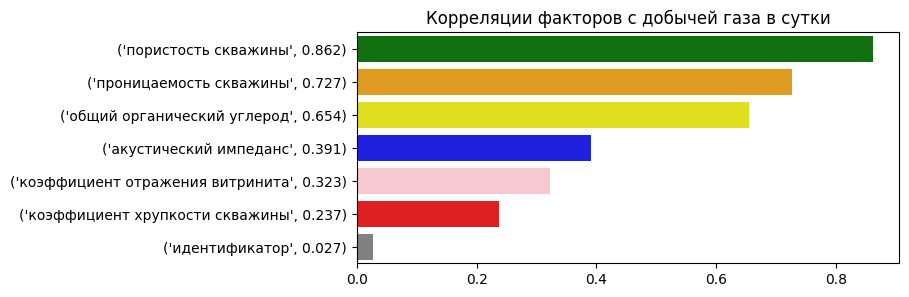

In [20]:
# отобразим корреляцию на тепловой карте
fig = plt.figure(figsize=(10, 4))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', vmin=-1, vmax=1, center=0)
plt.xticks(rotation=30);

# отобразим на столбчатой диаграмме кэффициенты корелляций между целевым признаком и остальными факторами
corr_target = data.corr()['добыча газа в сутки']
# преобразуем значения корреляций в модуль значения
values = corr_target.drop('добыча газа в сутки').apply(lambda x: abs(x)).sort_values(ascending=False).round(3)
# ось ординат отображает признаки
y_axes = list(values.index)
# ось абсцисс отображает значения коэффициентов корреляций с целевым
x_axes = list(values.values)
color = ['green', 'orange', 'yellow', 'blue', 'pink', 'red', 'grey']
plt.figure(figsize=(7,3))
plot = sns.barplot(y=y_axes, x=x_axes, palette=color)
# подпись оси ординат с указанием признака и его коэффициента корреляции
plot.set(yticklabels = zip(values.index, values.values))
plt.title('Корреляции факторов с добычей газа в сутки', fontsize = 12);

# с помощью функции np.corrcoef создаем матрицу корреляций, в качестве аргумента передаем матрицу значений датафрейма  
corr = np.corrcoef(data.values.T)
rank_corr = np.linalg.matrix_rank(corr)
deternimant = np.round(np.linalg.det(corr),5)
print(f'Ранг матрицы корреляций: {rank_corr}')
print('Определитель: {:.7f}'.format(deternimant))

<font color='blue'>**ВЫВОДЫ:**
* Ранг матрицы корреляций равен количеству столбцов-векторов, значит, все векторы системы линейно независимы.
* Определитель матрицы практически нулевой, это говорит, что матрица приближена к вырожденной, вырожденные матрицы не обратимы. При вычислении обратной матрицы мы делим на определитель, в нашем случае это возможно, но сразу стоит отметить, что такие модели неустойчивы.
* Такой определитель при максимальном ранге матрицы указывает на наличии мультиколлинеарности между признаками, а также возможно на отсутствие приведения значений признаков к единому масштабу (стандартизация/нормализация).
* Практически мы можем решить задачу классическим методом МНК, но доверять полученным результатам - нет. Так как наши исходные данные являются плохо обусловленными, прогностическая способность модели будет нарушена, она может быть и обратной и ошибочной.Прежде всего требуется избавление от мультиколлинерности, малозначимых признаков, которые создают шум, а также стандартизация данных.
* Признаки мультиколлинеарности мы наблюдаем у пористости и проницаемости скважины (0.76), пористости и огранического углерода (0.71)
* Наиболее значимыми для целевой переменной по методу Пирсона в матрице корреляций являются пористость, проницаемость, углерод.


### 3. Построение классической модели линейной регрессии по методу наименьших квадратов.

На данном этапе наша задача - это построение самой модели без оценки ее качества (в построенни участвует весь датасет без разбиения на выборки). Мы изучим только полученные коэффициенты регрессии.\
Уравнение классической линейной регрессии по МНК:
$$y=\vec{w}A$$
$$\vec{w}=\left(A^{T} A\right)^{-1} A^{T} \vec{y}$$
где $(A^T A)^{-1}$ - обратная матрица наблюдений, $A^T$ - транспонированная матрица, $\vec{w}$ - неизвестные коэффициенты уравнения регрессии, $\vec{y}$ - вектор правильных ответов



In [21]:
# исключаем из данных целевую переменную
data_ = data.drop('добыча газа в сутки', axis=1)
# создаем матрицу наблюдений
X = np.column_stack((np.ones(200), data_))     # добавляем вектор с единицами для вычисления свободного члена уравнения
# создаем вектор ответов: значения целевой переменной
y = data[['добыча газа в сутки']]
# решаем уравнение линейной регрессии по МНК, используем оператор умножения @
coef_vector = np.linalg.inv(X.T@X)@X.T@y
# полученные коэффициенты уравнения соотносим с факторами, свободный член -  W0
index = ['W0'] + data_.columns.to_list()
coef_vector.index = index
coef_vector = coef_vector.rename(columns={'добыча газа в сутки': 'коэффициенты уравнения линейной регрессии'})
print(coef_vector.round())

                                 коэффициенты уравнения линейной регрессии
W0                                                               -1232.000
идентификатор                                                        0.000
пористость скважины                                                230.000
проницаемость скважины                                             116.000
акустический импеданс                                             -365.000
коэффициент хрупкости скважины                                      25.000
общий органический углерод                                         -78.000
коэффициент отражения витринита                                    785.000


<font color='blue'>**ВЫВОДЫ:**
* Теперь мы математически доказали, что признак идентификатор неиформативен, его коэффициент = 0, то есть он никак не влияет на нашу целевую переменную.
* Свободный член W0 = -1232, это влияние внешних факторов, то есть без каких-либо факторов, присутствующих в наших данных, добыча газа снижается по других обстоятельствам.
* С ростом пористости пород в скважине на 1%, добыча газа увеличивается на 230 млн. кубических футов в сутки.
* А с ростом акустического импеданса на 1 измерения, наоборот, падает на 365 млн. кубических футов за сутки.

### 4. Предсказание целевой переменной на основе полученных коэффициентов уравнения линейной регрессии.

1. Сделаем прогноз выработки газа для новой скважины со следующими параметрами:
```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```
2. Вычислим абсолютную ошибку построенного прогноза для новой скважины, если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 
3. Спрогнозируем добычу газа для всех скважин из обучающего набора данных. Оценка качества прогноза будет производится по средней абсолютной ошибке в процентах MAPE и коэффициенту детерминации $R^2$, который отражает, насколько полно модель охватила зависимости в данных.
$$MAPE = \sum_{i=1}^n\frac{|y_i-\hat{y_i}|}{|y_i|}\frac{100}{n}$$

$$R^2 = 1 - \frac{MSE}{MSE_{mean}}$$
где $MSE = \frac{\sum_{i=1}^n{(y_i-\hat{y_i})}^2}{n}$

In [22]:
# создаем датафрейм для новой скважины
new_df = pd.DataFrame({
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }, index=[1])
# матрица значений новой скважины, объединенная с вектором-единицей для свободного интерсепта
new_X = np.column_stack((np.ones(1), new_df))[0]
print(new_X)
# подставляем значения новой скважины в уравнение линейной регрессии: y = Aw, умножение можно производить с помошью функции np.dot
new_well = np.dot(new_X, coef_vector)
print('Прогноз добычи газа для новой скважины: ', new_well.round(2)[0])

y_true = 4748.315024   # истинное значение
print('Абсолютная ошибка прогноза для новой скважины: ', (y_true - new_well).round(2)[0])
print('MAPE новой скважины: {:.2f} %'.format(mean_absolute_percentage_error(np.array([y_true]), new_well)*100))
print('--------------------------------')
# прогнозируем для всей обучающей выборки добычу газа - y_pred
# умножаем матрицу наблюдений (наша выборка без целевой переменной) на вектор коэффициентов, полученных из уравнения линейной регрессии
y_pred = X@coef_vector
print('Средняя абсолютная ошибка в процентах нашей модели линейной регрессии MAPE: {:.2f} %\n Коэффициент детерминации R2: {:.2f}'\
      .format(mean_absolute_percentage_error(y, y_pred)*100, r2_score(y, y_pred)))


[  1.   106.    15.32   3.71   3.29  55.99   1.35   2.42]
Прогноз добычи газа для новой скважины:  4723.06
Абсолютная ошибка прогноза для новой скважины:  25.25
MAPE новой скважины: 0.53 %
--------------------------------
Средняя абсолютная ошибка в процентах нашей модели линейной регрессии MAPE: 3.63 %
 Коэффициент детерминации R2: 0.96


<font color='blue'>**ВЫВОДЫ:**
* Коэффициент детерминации приближен к 1, что говорит о том, что наша модель практически полностью изучила все зависимости в данных и в результате ошибка составляет всего 3,63%.
* Так как мы не разбивали выборку на тренировочную и тестовую, оценить качество построенной модели линейной регрессии объективно сложно без использования на выборке с новыми данными. Мы находим коэффициенты уравнения, используя вектор правильных ответов, а затем делаем предсказание для этого же вектора.

### 5. Сравнительный анализ коэффициентов регрессии и коэффициентов корреляции.

In [23]:
# создадим датафрейм с коэффициентами регрессии и коэффициентами матрицы корреляций
corr_coef = pd.concat([corr_target.drop('добыча газа в сутки', axis=0).round(3), coef_vector.drop('W0', axis=0).round(3)], axis=1, ignore_index=True)
corr_coef = corr_coef.rename(columns={0: 'коэффициенты корреляции', 1: 'regr_coef'})
print(corr_coef)

                                 коэффициенты корреляции  regr_coef
идентификатор                                      0.027      0.051
пористость скважины                                0.862    230.179
проницаемость скважины                             0.727    116.239
акустический импеданс                             -0.391   -365.202
коэффициент хрупкости скважины                     0.237     24.994
общий органический углерод                         0.654    -78.401
коэффициент отражения витринита                    0.323    785.260


<font color='blue'>**ВЫВОДЫ:**
* Идентификатор - фактор с практически нулевым коэффициентом корреляции (практически отсутствие связи) и это отразилось и в уравнении регрессии: также околонулевой коэффициент (нет линейных взаимосвязей).
* Странное явление - коэффициент корреляции углерода с целевой переменной положительный, значит, при росте данного фактора добыча газа должна также увеличиваться, но полученный коэффициент уравнения этого вектора отрицательный: добыча газа снижается на 78 млн. куб.футов при учеличении на 1% углерода.
* Мы уже говорили о неустойчивости модели при вырожденности или высокой близости к вырожденности, и сейчас мы видим противоречие в коэффициентах регрессии с коэффициентами корреляций, которое может искажать результаты прогнозирования или даже давать обратный результат. Одним из факторов такого сбоя может быть разница в масштабе значений (единицах измерения), а также мультиколлинеарности/коллинеарности.

### 6. Отбор факторов, построение модели линейной регрессии с наиболее обусловленными факторами.

1. Исключим факторы, которые сильно коррелированные между собой (> 0.7).
2. Исключим факторы, которые практически не имеют линейной зависимости с целевой переменной (< 0.05).
3. Построим модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. 
4. Сделаем прогноз с помощью полученной модели и сравним с ответами предыдущей модели.

In [24]:
# создадим датафрейм с матрицей корреляций и отследим мультиколлинеарность
data.corr().style.highlight_between(left=0.700, right = 0.990, color='red')\
    .highlight_between(subset='добыча газа в сутки', left=0.00, right = 0.05, color='blue')

,идентификатор,пористость скважины,проницаемость скважины,акустический импеданс,коэффициент хрупкости скважины,общий органический углерод,коэффициент отражения витринита,добыча газа в сутки
идентификатор,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
пористость скважины,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
проницаемость скважины,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
акустический импеданс,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
коэффициент хрупкости скважины,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
общий органический углерод,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
коэффициент отражения витринита,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
добыча газа в сутки,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


In [25]:
'''
Таким образом, из наших данных мы удаляем следующие признаки:
1) идентификатор с коэффициентом корреляции с целевой переменной в 0.027,
2) проницаемость скважины (мультиколлинеарен с пористостью, но менее скоррелирован с целевым),
3) общий органический углерод (сильная корреляция с пористостью 0.712)
'''
# исключаем отобранные факторы и целевую переменную из данных
data_2 = data.drop(['идентификатор', 'проницаемость скважины', 'общий органический углерод', 'добыча газа в сутки'], axis=1)

# создаем матрицу наблюдений после удаления признаков
X_train = np.column_stack((np.ones(200), data_2))

# решаем уравнение линейной регрессии по МНК
coef_w = np.linalg.inv(X_train.T@X_train)@X_train.T@y

# соотносим полученные коэффициенты регрессии с факторами
coef_w.index = ['W0'] + data_2.columns.to_list()
coef_w.rename(columns={'добыча газа в сутки': 'коэффициенты регрессии'}, inplace=True)

print('Коэффициенты регрессии до удаления сильно кореллированных факторов:', coef_vector, sep='\n')
print('--------------------------')
print('Коэффициенты регрессии после удаления сильно кореллированных факторов:', coef_w.round(), sep='\n')
print('--------------------------')
# делаем предсказание для целевой переменной
y_predict = X_train@coef_w
print('Средняя абсолютная ошибка в процентах нашей модели линейной регрессии MAPE: {:.2f} %\n Коэффициент детерминации R2: {:.3f}'\
      .format(mean_absolute_percentage_error(y, y_predict)*100, r2_score(y, y_predict)))

Коэффициенты регрессии до удаления сильно кореллированных факторов:
                                 коэффициенты уравнения линейной регрессии
W0                                                               -1232.308
идентификатор                                                        0.051
пористость скважины                                                230.179
проницаемость скважины                                             116.239
акустический импеданс                                             -365.202
коэффициент хрупкости скважины                                      24.994
общий органический углерод                                         -78.401
коэффициент отражения витринита                                    785.260
--------------------------
Коэффициенты регрессии после удаления сильно кореллированных факторов:
                                 коэффициенты регрессии
W0                                            -1835.000
пористость скважины                            

<font color='blue'>**ВЫВОДЫ:**
* Мы исключили противоречие между коэффициентами корреляций и коэффициентами регрессии, коэффициенты регрессии изменились в значениях довольно сильно.
* Теперь изменение пористости скважины на 1% улучшает объем добычи газа на 293 млн.куб.футов, а коэффициенты регрессии импеданса и витринита говорят о меньшем влиянии на добычу газа по сравнению с предыдущей моделью.
* Оценка качества модели на обучающей выборке после исключения факторов немного улудшилась согласно MAPE и R2 (4.04% и 0.945). 
* Объективной оценки мы не имеем без валидационной выборки.

### 7. Построение модели линейной регрессии с помощью библиотеки sklearn.

In [26]:
# инициализируем алгоритм линейной регрессии
model = LinearRegression(fit_intercept=False)
# обучаем модель
model.fit(X_train, y)
# делаем предсказание
y_pred = model.predict(X_train)

# создаем датафрейм  с факторами и коэффициентами регрессии построенной модели
df_w = pd.DataFrame({'Факторы': ['Intercept'] + data_2.columns.tolist(), 'Коэффициенты регрессии': model.coef_.round().tolist()[0]})
print(df_w)
print('---------------------------------')
# оцениваем предсказания целевой переменной
print('Средняя абсолютная ошибка в процентах нашей модели линейной регрессии MAPE: {:.2f} %\n Коэффициент детерминации R2: {:.3f}'\
      .format(mean_absolute_percentage_error(y, y_pred)*100, r2_score(y, y_pred)))

                           Факторы  Коэффициенты регрессии
0                        Intercept               -1835.000
1              пористость скважины                 293.000
2            акустический импеданс                -200.000
3   коэффициент хрупкости скважины                  28.000
4  коэффициент отражения витринита                 517.000
---------------------------------
Средняя абсолютная ошибка в процентах нашей модели линейной регрессии MAPE: 4.04 %
 Коэффициент детерминации R2: 0.945


<font color='blue'>**ВЫВОДЫ:**\
Аналитическое решение задачи с помощью алгоритма Linear Regression библиотеки sklearn дало идентичные результаты с нашим ручным решением уравнения линейной регрессии по МНК.

## Полиномиальная регрессия и регуляризация

А теперь мы приступаем ко второй части нашей задачи.\
Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Так как полиномиальным моделям очень легко переобучиться под исходную выборку, то для контроля качества модели мы будем использовать кросс-валидацию. 

### 1. Построение линейной регрессии с помощью sklearn на полиномиальных признаках. 

Для успешной сходимости численных методов оптимизации необходима стандартизация, приведение всех данных к одинаковым единицам измерения. Стандартизация изменяет распределение признака так, чтобы среднее значение стало равно 0, а стандартное отклонение равнялось 1. Стандартизация используется на данных, имеющих нормальное распределение, в нашем датасете нет идеального нормального распределения, но гистрограммы показали схожесть с нормальным Гуассовым распределением всех признаков. Мы воспользуемся классом StandartScaler из библиотеки sklearn.

Затем сгенерируем полиномиальные признаки третьего порядка с помощью класса PolynomialFeatures из библиотеки sklearn.

На основе полиномиальных признаков построим линейную регрессию и оценим ее качество на тренировочной и валидационной выборке с помощью кросс-валидации, для этого воспользуемся функцией cross_validate().

In [27]:
# формируем матрицу наблюдений без признаков, которые мы исключили на предыдущем этапе
X = data.drop(['идентификатор', 'проницаемость скважины', 'общий органический углерод', 'добыча газа в сутки'], axis=1)
# вектор правильных ответов
y = data['добыча газа в сутки']
# стандартизируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# генерируем полиномиальные признаки 3-й степени
poly = PolynomialFeatures(degree=3, include_bias=False)
X_scaled_poly = poly.fit_transform(X_scaled)
print('Количество факторов до генерации полиномиальных: ', X.shape[1])
print('Количество факторов после создания полиномиальных факторов 3 степени: ', X_scaled_poly.shape[1])
print('--------------------------')
# создаем модель
lr = LinearRegression()
# список метрик, по которым мы будем оценивать качество построенной модели: MAPE и R2
scoring = ['neg_mean_absolute_percentage_error', 'r2']
# передаем в кросс-валидационную функцию наши данные и модель
scores = cross_validate(lr, X_scaled_poly, y, scoring=scoring, cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.3f} %'.format(-scores['train_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на тренировочных фолдах: {:.3}'.format(scores['train_r2'].mean()))
print('--------------------------')
print('MAPE на валидационных фолдах: {:.3f} %'.format(-scores['test_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на валидационных фолдах: {:.3f}'.format(scores['test_r2'].mean()))

Количество факторов до генерации полиномиальных:  4
Количество факторов после создания полиномиальных факторов 3 степени:  34
--------------------------
MAPE на тренировочных фолдах: 1.773 %
R2 на тренировочных фолдах: 0.99
--------------------------
MAPE на валидационных фолдах: 2.681 %
R2 на валидационных фолдах: 0.975


<font color='blue'>**ВЫВОДЫ:**
* Мы значительно улучшили качество модели, ошибка теперь очень небольшая как на тренировочных данных, так и на валидационных выборках, разброса между ними нет, значит переобучения у модели не произошло.
* Коэффициент детерминации практически равен максимуму, модель хорошо изучила связи и нашла закономерности.

### 2. Полиномиальная регрессия с $L_1$-регуляризацией Lasso.

$${‖\overrightarrow{y}-A\overrightarrow{w}‖}^2+α\sum^k_{i=0}{}{|w}_i|→min$$
Основная идея заключается в обнулении коэффициентов, относящихся к коллинеарным или высококоллинеарным факторам, тем самым, исключая эти факторы из уравнения, система сохраняет линейную независимость между факторами.

Определяющим гиперпараметром в линейной регрессии с регуляризацией, конечно, является коэффициент регуляризации alpha $α$.\
Для его подбора мы воспользуемся базовым оптимизатором библиотеки sklearn RandomizedSearchCV.

In [28]:
# задаем сетку гиперпараметров для рандомного перебора
param_distributions= [{'alpha': np.linspace(0.1, 5, 100, dtype=float)}      # коэффициент регуляризации
]
# создаем объект класса RandomizedSearchCV и передаем гиперпараметры
random_search_lasso = RandomizedSearchCV(
    estimator=Lasso(random_state=42),                                      # алгоритм линейной регрессии с L1-регуляризацией
    param_distributions=param_distributions,                               # сетка гиперпараметров
    cv=5,                                                                  # количество фолдов при кросс-валидации
    scoring='neg_mean_absolute_percentage_error',                          # метрика оценки качества MAPE
    n_iter = 50,                                                           # количество случайных комбинаций 
    n_jobs = -1
)  
# обучаем модель
random_search_lasso.fit(X_scaled_poly, y) 
# выводим наилучшие значения гиперпараметров после рандомного перебора
print('Наилучшие значения гиперпараметров: {}'.format(random_search_lasso.best_params_))
# выводим значение метрики MAPE при кросс-валидации
print('Наилучшее значение MAPE при кросс-валидаци: {:.3f}%'.format(-random_search_lasso.best_score_))
print('--------------------------')

# применим найденные гиперпараметры для регрессии с L1-регуляризацией к нашим данным
lasso = Lasso(alpha=random_search_lasso.best_params_['alpha'], random_state=42)
# передаем в кросс-валидационную функцию наши данные и модель
scores_l = cross_validate(lasso, X_scaled_poly, y, scoring=scoring, cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-scores_l['train_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на тренировочных фолдах: {:.3f}'.format(scores_l['train_r2'].mean()))
print('--------------------------')
print('MAPE на валидационных фолдах: {:.3f} %'.format(-scores_l['test_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на валидационных фолдах: {:.3f}'.format(scores_l['test_r2'].mean()))

Наилучшие значения гиперпараметров: {'alpha': 4.752525252525253}
Наилучшее значение MAPE при кросс-валидаци: 0.023%
--------------------------
MAPE на тренировочных фолдах: 1.824 %
R2 на тренировочных фолдах: 0.988
--------------------------
MAPE на валидационных фолдах: 2.276 %
R2 на валидационных фолдах: 0.982


<font color='blue'>**ВЫВОДЫ:**
* И вновь нам удалось немного улучшить качество модели 2.681% >>> 2.276% MAPE

### 3. Полиномиальная регрессия с $L_2$-регуляризацией Ridge.

$${‖\overrightarrow{y}-A\overrightarrow{w}‖}^2+α\sum^k_{i=0}{}{(w}_i)^2→min$$
Совершаем те же действия, что сделали для $L_1$-регуляризации.
Если в Lasso мы накладываем штраф на сумму модулей весов, то при $L_2$-регуляризации мы штрафуем длину вектора весов $\vec{w}$.
$${\widehat{\overrightarrow{w}}}_{ridge}={\left(A^TA+\alpha E\right)}^{-1}A^T \overrightarrow{y}$$
Мы прибавляем единичную матрицу Е с каким-то коэффициентом, которая исправляет матрицу $A^TA$, если она близка к вырожденной или такой является, тем самым мы создаем линейную независимость между столбцами матрицы.


In [29]:
# задаем сетку гиперпараметров для рандомного перебора
param_distributions= [{'alpha': np.linspace(0.01, 5, 100, dtype=float)}     # коэффициент регуляризации
]
# создаем объект класса RandomizedSearchCV и передаем гиперпараметры
random_search_ridge = RandomizedSearchCV(
    estimator=Ridge(random_state=42),                                      # алгоритм линейной регрессии с L2-регуляризацией
    param_distributions=param_distributions,                               # сетка гиперпараметров
    cv=5,                                                                  # количество фолдов при кросс-валидации
    scoring='neg_mean_absolute_percentage_error',                          # метрика оценки качества MAPE
    n_iter = 50,                                                           # количество случайных комбинаций 
    n_jobs = -1
)  
# обучаем модель
random_search_ridge.fit(X_scaled_poly, y) 
# выводим наилучшие значения гиперпараметров после рандомного перебора
print('Наилучшие значения гиперпараметров: {}'.format(random_search_ridge.best_params_))
# выводим значение метрики MAPE при кросс-валидации
print('Наилучшее значение MAPE при кросс-валидаци: {:.3f}%'.format(-random_search_ridge.best_score_))
print('--------------------------')

# применим найденные гиперпараметры для регрессии с L2-регуляризацией к нашим данным
ridge = Ridge(alpha=random_search_ridge.best_params_['alpha'], random_state=42)
# передаем в кросс-валидационную функцию наши данные и модель
scores_r = cross_validate(ridge, X_scaled_poly, y, scoring=scoring, cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-scores_r['train_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на тренировочных фолдах: {:.3f}'.format(scores_r['train_r2'].mean()))
print('--------------------------')
print('MAPE на валидационных фолдах: {:.3f} %'.format(-scores_r['test_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на валидационных фолдах: {:.3f}'.format(scores_r['test_r2'].mean()))

Наилучшие значения гиперпараметров: {'alpha': 0.21161616161616165}
Наилучшее значение MAPE при кросс-валидаци: 0.027%
--------------------------
MAPE на тренировочных фолдах: 1.774 %
R2 на тренировочных фолдах: 0.990
--------------------------
MAPE на валидационных фолдах: 2.673 %
R2 на валидационных фолдах: 0.975


<font color='blue'>**ВЫВОДЫ:**\
Ridge-регуляризация снизила качество нашей линейной регрессии: lr (MAPE=2.681 %) > ridge (MAPE=2.672 %) > lasso(MAPE=2.276 %)


### 4. Полиномиальная регрессия с ElasticNet-регуляризацией.

ElasticNet-регуляризация - это комбинация $L_1$ и $L_2$ -регуляризации.
$${\|\overrightarrow{y}-A\overrightarrow{w}\|}^2+\alpha \cdot \lambda \sum^k_{i=0}{}{|w}_i|+\frac{\alpha \cdot (1-\lambda )}{2}\sum^k_{i=0}{}{(w}_i)^2\to min$$
Вновь воспользуемся помощью оптимизатора для поиска оптимальных коэффициентов обеих регуляризаций.\
А затем построим модель и посмотрим на значения метрик для сравнения с предыдущими результатами.

In [30]:
# задаем сетку гиперпараметров для рандомного перебора
param_distributions= [{'alpha': np.linspace(0.1, 5, 100, dtype=float),      # коэффициент L1-регуляризации
              'l1_ratio': np.linspace(0.05, 5, 100, dtype=float)}           # коэффициент L2-регуляризации
]
# создаем объект класса RandomizedSearchCV и передаем гиперпараметры
random_search_elast = RandomizedSearchCV(
    estimator=ElasticNet(random_state=42),                                 # алгоритм линейной регрессии с L1 и L2-регуляризацией
    param_distributions=param_distributions,                               # сетка гиперпараметров
    cv=5,                                                                  # количество фолдов при кросс-валидации
    scoring='neg_mean_absolute_percentage_error',                          # метрика оценки качества MAPE
    n_iter = 300,                                                          # количество случайных комбинаций 
    n_jobs = -1
)  
# обучаем модель
random_search_elast.fit(X_scaled_poly, y) 
# выводим наилучшие значения гиперпараметров после рандомного перебора
print('Наилучшие значения гиперпараметров: {}'.format(random_search_elast.best_params_))
# выводим значение метрики MAPE при кросс-валидации
print('Наилучшее значение MAPE при кросс-валидаци: {:.3f}%'.format(-random_search_elast.best_score_))
print('--------------------------')

# применим найденные гиперпараметры для регрессии с L1-регуляризации к нашим данным
elastic = ElasticNet(alpha=random_search_elast.best_params_['alpha'], l1_ratio=random_search_elast.best_params_['l1_ratio'],
                     max_iter = 5000, random_state=42)
# передаем в кросс-валидационную функцию наши данные и модель
scores_el = cross_validate(elastic, X_scaled_poly, y, scoring=scoring, cv=5, return_train_score=True)

print('MAPE на тренировочных фолдах: {:.3f} %'.format(-scores_el['train_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на тренировочных фолдах: {:.3f}'.format(scores_el['train_r2'].mean()))
print('--------------------------')
print('MAPE на валидационных фолдах: {:.3f} %'.format(-scores_el['test_neg_mean_absolute_percentage_error'].mean()*100))
print('R2 на валидационных фолдах: {:.3f}'.format(scores_el['test_r2'].mean()))

Наилучшие значения гиперпараметров: {'l1_ratio': 1.0, 'alpha': 4.257575757575758}
Наилучшее значение MAPE при кросс-валидаци: 0.023%
--------------------------
MAPE на тренировочных фолдах: 1.817 %
R2 на тренировочных фолдах: 0.989
--------------------------
MAPE на валидационных фолдах: 2.280 %
R2 на валидационных фолдах: 0.982


<font color='blue'>**ВЫВОДЫ:**\
Мы большом количестве перебора комбинаций коэффициентов регуляризаций мы достигаем тех же значений метрики, что и при $L_1$-регуляризации = 2.280%

### 5. Сравнение значений метрик построенных моделей.

In [31]:
# задаем формат числовой ячейки
pd.set_option('display.float_format', '{:.3f}'.format)
# создаем датафрейм с результатами всех построенных моделей
score_data = pd.DataFrame({
    'Model': ['LinearRegression', 'Polinomial Regression', 'Polinomial Regression Lasso', 'Polinomial Regression Ridge', 
              'Polinomial Regression ElasticNet'],
    'Hyperparameters': [False, False, random_search_lasso.best_params_, random_search_ridge.best_params_, 
                        random_search_elast.best_params_],
    'PolinomialFeatures': [False, True, True, True, True],
    'MAPE on train folds': [mean_absolute_percentage_error(y, y_pred)*100,
                            -scores['train_neg_mean_absolute_percentage_error'].mean()*100, 
                            -scores_l['train_neg_mean_absolute_percentage_error'].mean()*100, 
                            -scores_r['train_neg_mean_absolute_percentage_error'].mean()*100, 
                            -scores_el['train_neg_mean_absolute_percentage_error'].mean()*100],
    'MAPE on valid folds': [None, -scores['test_neg_mean_absolute_percentage_error'].mean()*100, 
                            -scores_l['test_neg_mean_absolute_percentage_error'].mean()*100,
                              -scores_r['test_neg_mean_absolute_percentage_error'].mean()*100,
                               -scores_el['test_neg_mean_absolute_percentage_error'].mean()*100]
    })

score_data

,Model,Hyperparameters,PolinomialFeatures,MAPE on train folds,MAPE on valid folds
0,LinearRegression,False,False,4.044,NaN
1,Polinomial Regression,False,True,1.773,2.681
2,Polinomial Regression Lasso,{'alpha': 4.752525252525253},True,1.824,2.276
3,Polinomial Regression Ridge,{'alpha': 0.21161616161616165},True,1.774,2.673
4,Polinomial Regression ElasticNet,"{'l1_ratio': 1.0, 'alpha': 4.257575757575758}",True,1.817,2.280


<font color='red'>**ЗАКЛЮЧЕНИЕ:**</font>
* Мы показали важность корреляционного анализа, так мультиколлинеарность в наших данных может приводить к неустойчивости коэффициентов. До начала моделирования мы должны оставить только те признаки в данных, которые являются значимыми для целевой переменной и хорошо обусловленными и не исказят будущий прогноз модели.
* Из сравнительной таблицы мы видим, что наилучшей моделью, которая решает задачу с минимальной ошибкой, является линейная регрессия на полиномиальных признаках с $L_1$-регуляризацией с коэффициентом $alpha$=4.56. Именно ее мы и предложим нашему заказчику Василию.
* ElasticNet модель показывает практически тот же результат, но это за счет того, что по сути оптимальным оказалась L1-регуляризация, L1_ratio=1, то есть L2-регуляризация "отключена".
* Так как мы не наблюдали большого разброса между значениями метрик на тренировочных и валидационнных фолдах, то можно говорить, что наши модели не переобучились, но показали практически максимальную изученность данных. Датасет очень маленький и сложно объективно оценить переобучение.
* А также мы установили факторы, которые более всего влияют на добычу газа: пористость скважины - положительно при увеличении, акустический импеданс - отрицательно при увеличении.